### An Introduction to Value At Risk

#### Introduction

Let $X$ be a random variable describing our financial position,
so that higher values of $X$ represents outcomes convenient to us 
(for instance the value of a stock we own).
We are interested in modeling the *risk* associated to $X$.
Traditionally, a quick way to describe this uncertainty is given by
the standard variation $\sigma(X)$, because it determines how likely it is
to have outcomes far from the expected value (Chebyshev inequality).
But when dealing with risk, this notion is not enough: we are indeed more
interested in unexpected losses, unfavorable outcomes, while the variance
is intrinsecally symmetric (due to its squared difference in the definition).

Therefore the need for more advanced tools.

#### Monetary Risk Measures

Let now $\rho :  \mathbb{R} \to \mathbb{R}$ be a generic function.
We want to define it so that $\rho(X)$ becomes capable of capturing
the notion of "risk of the position $X$".
The literature is vast and offers dozens of definitions,
each with pros and cons, as for instance extensively described in the
book *Stochastic Finance* by Follmer.
To analyze them would go far beyond our purposes, instead we will focus on some
key mathematical propereties before moving to the simplest
"realistic" case in the next section (*Value at Risk*).

A first trivial convention is that lower values of $\rho(X)$ should indicate
more convenient scenarios ("risk minimization"), while
another requirement is given by:
 - *cash-invariance*: $\rho(X + m) = \rho(X) - m$ for each $m \in \mathbb{R}$;

The cash-invariance property is interpreted as the fact that if we had more 
money $m$ at
disposal when getting a position $X$, the overall risk would reduce since that
capital could be used to countereffect possible negative outcomes, leading to
better overall final position (e.g. avoiding bankrupt).

Any position $Y$ is called *acceptable* if and only if $\rho(Y) \leq 0$.
Observing that $\rho(Y + \rho(Y)) = 0$ we deduce that
any monetary risk measure $\rho(X)$ can be interpreted as the minimal amount 
of money needed to make a position $X$ acceptable.

If on the one hand the definition of $\rho$ would change from case to case,
on the other hand the philosophy as above remains the same.


#### Quantiles
Let $X$ be a real random variable.
The comulative distribution function of $X$ is defined as:
$F: \mathbb{R} \to [0,1]$, such that $F(t) = P[X \leq t ]$.
The function $F$ is always increasing, but for simplicity we assume to
be continuous and strictly monotonic increasing.
These assumptions allow to quickly define
the *quantile* function $Q: [0,1] \to \mathbb{R}$ simply as $F^{-1}$
without any further remarks: $Q(\lambda) = t$ 
where $t$ is the only value such that
$P[X \leq t] = \lambda$.

In case of discontinuous or not strictly increasing cdf (happening for instance
when working with discrete random variables), quantiles can still be
defined, but the mathematical details need to check
each property go beyond the purpose of this notebook.

Quantile represents a very strong tool to study probability distribution,
and for instance there are statistical tests based on them (Q-Q plots,...),
and we encourage the reader in leraning more about them if not already done.


We comment now the task of computing the quantiles in practice, when
dealing with finite empirical samples. 
Let's suppose that we have $N$ samples (numbers), and that we are 
interested in the $p$ quantile (we chose "p" for "probability"),
e.g. the "true" value $Q(p)$ such that
$P[X \leq Q(p)] = p$.


Our idea follows:
 - sort all the samples $X_0, \dots, X_{N-1}$ in ascending oder;
 - take $k = floor(N p)$;
 - if $k \geq 1$, then we take as approximated quantile the number
       $X_{k-1}$ (more explanation follows).
       Otherwise we can only claim that the quantile is stricly
       inferior than $X_0$ and return an attached warning message.


Recall that for any $x \in \mathbb{R}$ we have
$floor(x) \leq x < floor(x) + 1$, and since the samples are sorted
with indeces starting from $0$, the following holds:
 - $P[X \leq X_{k-1}] = \frac{k}{N} = 
        \frac{floor(N p)}{N} \leq \frac{Np}{N} = p$
 - $P[X \leq X_{k}] = \frac{k+1}{N} =
       \frac{floor(Np) + 1}{N}> \frac{Np}{N} = p$


These formulas implie that, according to the given empirical samples,
the true quantile satisfying
$P[X \leq Q(p)] = p$ must lie in the interval
$[X_{k-1}, X_{k})$.
For simplicity we just return the value $X_{k-1}$.

The following code implements these ideas.





In [1]:
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
def get_quantile (given_samples : np.array, p : float,
                            verbose=True) -> float:
    '''
    The array given_samples contains the samples (real numbers), while
    p is the target probability strictly between 0 and 1.
    The function returns a quantile estimation according to the sorting
    strategy.
    '''
    assert(p > 0. and p < 1.)
    # Sort samples in ascending order
    samples = np.sort(given_samples.reshape(-1,))
    n_samples = samples.shape[0]
    assert(n_samples >= 2)
    # Convert the probability p into "how many elements" 
    # from the sorted samples has to be taken until reaching p.
    # Example: if the samples are 100 sorted number, 
    # take the first 80 to realize the 80% quantile.
    idx_low = int(np.floor(n_samples * p))
    if idx_low == 0:
        print(f"Quantile {p} is too small for num samples {n_samples}")
        return samples[0]
    idx_low = idx_low - 1
    idx_up = int(idx_low + 1)
    # q_low is the lower bound in the interval, while...
    q_low = samples[idx_low]
    # q_up is the upper bound.
    q_up = samples[idx_up]
    # Double check that the two elements approximate the desired quantile
    p_low = np.sum(samples <= q_low) / n_samples
    p_up = np.sum(samples <= q_up) / n_samples
    # We must have: p_low <= p, and p_up > p.
    if not ((p_low <= p) and (p_up >= p)):
        print(f"{p_low} > {p} or {p_up} < {p}")
        assert False
        # I need to adjust a bit better the code above
        
    
    if verbose:
        print(f"From get_quantile:")
        print(f"\t{p*100:.3f}%-quantile in [{q_low:.3e}, {q_up:.3e})")
        print(f"\t{p*100:.3f}%-quantile is {q_low:.3e}") 
        print(f"\tP [X <= {q_low :.3e}] = {p_low : .3e} <= {p : .3e}")
        print(f"\tP [X <= {q_up:.3e}] = {p_up : .3e} >= {p : .3e}")
        print("-")
    return q_low
#---


In [3]:
def error_analysis(true_value, p):
        '''
        Perform an error analysis for the get_quantile
        function, based on the known quantile values for the normal
        distribution.
        '''
        n_exponents = 5
        base = 5
        exponents = range(base, base + n_exponents)
        mean_errors = []
        for power in exponents:
                n_simulations = 100
                n_samples = int(math.pow(2., power))
                simu_errors = np.zeros(n_simulations)
                for nth_simu in range(n_simulations):
                        samples = np.random.normal(0., 1., (n_samples,)) 
                        result = get_quantile(samples, p, verbose = False)
                        tmp = np.abs(true_value - result)
                        # choose relative errors
#                        simu_errors[nth_simu] = tmp * 100. / np.abs(true_value)
                        # or choose absolute errors
                        simu_errors[nth_simu] = tmp
                mean_errors.append(simu_errors.mean())
        return (exponents, mean_errors)
#----

In [4]:
err_1, res_1 = error_analysis(1.6449, 0.95)
err_2, res_2 = error_analysis(-0.8416, 0.20)
err_3, res_3 = error_analysis(0., 0.50)
err_4, res_4 = error_analysis(-1.96, 0.025)

Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.02

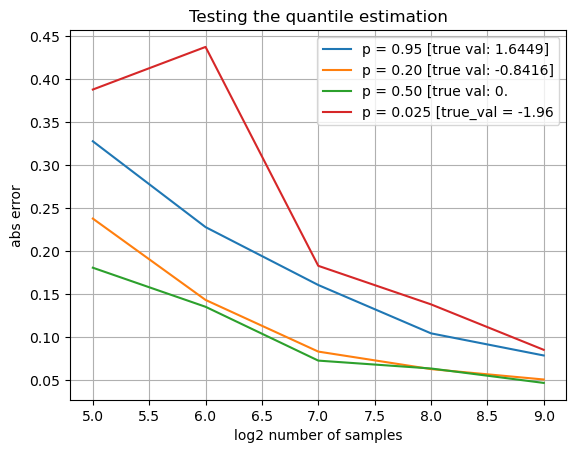

In [5]:
plt.plot(err_1, res_1, label = "p = 0.95 [true val: 1.6449]")
plt.plot(err_2, res_2, label = "p = 0.20 [true val: -0.8416]")
plt.plot(err_3, res_3, label = "p = 0.50 [true val: 0.]")
plt.plot(err_4, res_4, label = "p = 0.025 [true_val = -1.96")
plt.grid()
plt.title("Testing the quantile estimation")
plt.xlabel("log2 number of samples")
plt.ylabel("abs error")
plt.legend()
plt.show()

#### Value At Risk (TO DO)

Given a financial position $X$ and a *confidence level* $\lambda \in [0, 1]$,
the Value At Risk is defined on the base of quantiles:
$VaR_{\lambda}(V) = Q_{1 - \lambda} (-V)$

The following proposition helps in interpreting the definition:

Proposition: $VaR_{\lambda}(V) = m$ such that $P[V + m < 0] \leq \lambda $


Therefore the VaR can be interpreted as the amount of money that, when added
to the position $X$, make the probability of an overall loss lower than a
selected safety level. Note that in this notation, we want $\lambda$ to be
"small enough". Other resources uses the letter $c = 1 - \lambda$ calling it
the "confidence level". We hope that the context would clarify the chosen
definitions in order to avoid any ambiguity.

Finally by setting $\rho(X) = VaR(X)$ the cash-inavriance property can be
proved making the Value At Risk a monetary risk measure.

Just to clarify, one wants to:
 - choose lambda very small, to stay "safer";
 - minimize the values at risk


HERE SOME CODE TO COMPUTE THE VAR BASED ON THE QUANTILE INTERPRETATION